#Colab Install Environment

In [1]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 3.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███

#GCN

In [2]:
import networkx as nx
import numpy as np
from sklearn.preprocessing import StandardScaler

In [3]:
# load graph from networkx library
G = nx.karate_club_graph()

# retrieve the labels for each node
labels = np.asarray([G.nodes[i]['club'] != 'Mr. Hi' for i in G.nodes]).astype(np.int64)

# create edge index from 
adj = nx.to_scipy_sparse_matrix(G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

# using degree as embedding
embeddings = np.array(list(dict(G.degree()).values()))

# normalizing degree values
scale = StandardScaler()
embeddings = scale.fit_transform(embeddings.reshape(-1,1))

#Details

In [4]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [5]:
adj

<34x34 sparse matrix of type '<class 'numpy.int64'>'
	with 156 stored elements in COOrdinate format>

In [6]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33))

In [7]:
G.degree()

DegreeView({0: 16, 1: 9, 2: 10, 3: 6, 4: 3, 5: 4, 6: 4, 7: 4, 8: 5, 9: 2, 10: 3, 11: 1, 12: 2, 13: 5, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 3, 20: 2, 21: 2, 22: 2, 23: 5, 24: 3, 25: 3, 26: 2, 27: 4, 28: 3, 29: 4, 30: 4, 31: 6, 32: 12, 33: 17})

In [8]:
for i in range(len(G)):
  print(G.nodes[i]['club'])

Mr. Hi
Mr. Hi
Mr. Hi
Mr. Hi
Mr. Hi
Mr. Hi
Mr. Hi
Mr. Hi
Mr. Hi
Officer
Mr. Hi
Mr. Hi
Mr. Hi
Mr. Hi
Officer
Officer
Mr. Hi
Mr. Hi
Officer
Mr. Hi
Officer
Mr. Hi
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer
Officer


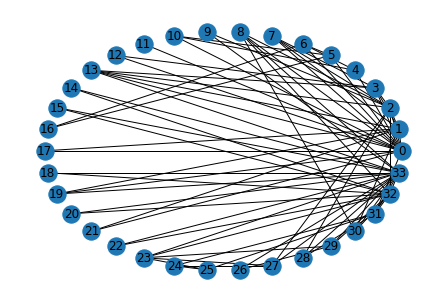

In [9]:
nx.draw_circular(G, with_labels=True)

#Train

In [10]:
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data
from sklearn.model_selection import train_test_split
import torch_geometric.transforms as T

# custom dataset
class KarateDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(KarateDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        
        data.num_nodes = G.number_of_nodes()
        
        # embedding 
        data.x = torch.from_numpy(embeddings).type(torch.float32)
        
        # labels
        y = torch.from_numpy(labels).type(torch.long)
        data.y = y.clone().detach()
        
        data.num_classes = 2

        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(list(G.nodes())), 
                                    pd.Series(labels),
                                    test_size=0.30, 
                                    random_state=42)
        
        n_nodes = G.number_of_nodes()
        
        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
    
dataset = KarateDataset()
data = dataset[0]

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# GCN model with 2 layers 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, int(data.num_classes))

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data =  data.to(device)

model = Net().to(device) 

In [16]:
torch.manual_seed(42)

optimizer_name = "RAdam"
lr = 1e-4
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
epochs = 500

def train():
  model.train()
  optimizer.zero_grad()
  F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
  optimizer.step()

@torch.no_grad()
def test():
  model.eval()
  logits = model()
  mask1 = data['train_mask']
  pred1 = logits[mask1].max(1)[1]
  acc1 = pred1.eq(data.y[mask1]).sum().item() / mask1.sum().item()
  mask = data['test_mask']
  pred = logits[mask].max(1)[1]
  acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
  return acc1,acc

for epoch in range(1, epochs):
  train()

train_acc,test_acc = test()

print('#' * 70)
print('Train Accuracy: %s' %train_acc )
print('Test Accuracy: %s' % test_acc)
print('#' * 70)

######################################################################
Train Accuracy: 0.9130434782608695
Test Accuracy: 0.7272727272727273
######################################################################
